## Note:
this is a workbook notebook for testing the cnn model... the final notebook will have much more examples and will have visualization on how the data looks

In [29]:
%matplotlib inline
# General imports
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import random
from collections import Counter, defaultdict
from operator import itemgetter
import matplotlib.pyplot as plt


#keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate

# Custom functions
%load_ext autoreload
%autoreload 2
import database_selection
import vectorization
import helpers
import icd9_cnn_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
#reading file
full_df = pd.read_csv('../data/disch_notes_all_icd9.csv',
                 names = ['HADM_ID', 'SUBJECT_ID', 'DATE', 'ICD9','TEXT'])


In [22]:
full_df.shape

(52696, 5)

In [23]:
# taking just a subset of the records for developing models
df = full_df.sample(frac=0.1).reset_index(drop=True)
print df.shape
df.head(10)

(5270, 5)


,HADM_ID,SUBJECT_ID,DATE,ICD9,TEXT
0,101809,28707,2169-06-28 00:00:00,4271 3453 3481 486 5856 7907 40391 4280 4240 4...,Admission Date: [**2169-6-22**] ...
1,176869,97567,2200-07-06 00:00:00,51901 43820 6821 43811,Admission Date: [**2200-7-4**] D...
2,169625,26384,2185-10-31 00:00:00,486 4280 4241 41401 41092,Admission Date: [**2185-10-27**] Discha...
3,126258,3014,2110-02-17 00:00:00,76502 769 7742 7793 77181 74602 7702 7707 7757...,Admission Date: [**2109-12-21**] Discha...
4,109645,68083,2116-08-14 00:00:00,29181 34982 5849 27651 30390 311 5641 2859 287...,Admission Date: [**2116-8-11**] ...
5,129600,7468,2194-09-26 00:00:00,51882 431 41041 3229 2761 4019 2859,Admission Date: [**2194-9-19**] Dischar...
6,153003,17659,2200-06-21 00:00:00,99604 42731 4280 8670 5997 45829 7802 412 4148...,Admission Date: [**2200-6-19**] ...
7,108708,19287,2198-10-11 00:00:00,769 77211 7793 7742 76524 76516 7678 77081 6910,Admission Date: [**2198-8-28**] Dischar...
8,158867,32078,2183-08-13 00:00:00,43889 3453 4019 2724 2662 72210,Admission Date: [**2183-8-6**] D...
9,107032,30163,2111-04-12 00:00:00,5121 47874 9982 56889 99881 4019 73399,Admission Date: [**2111-4-9**] D...


## Pre processing ICD 9 codes

In [5]:
# instead of finding out the top 20 leave icd-9 codes and filter records based on that
# we will use all records and replace the leave icd-9 codes with its grandparents code in the first level of the hierarchy
#N_TOP = 20 
#full_df, top_codes = database_selection.filter_top_codes(df, 'ICD9', N_TOP, filter_empty = True)
#df = full_df.head(1000)

### Replacing leave icd-9 codes with their grandparent icd-9 code in the first level of the hierarchy

Source: https://github.com/sirrice/icd9   
The code above let's you see the ICD-9 hierarchy and traverse it, getting the parents (path) of a node, the children of a node, siblings, etc. (well documented in its README file).  

From looking at the top of the hierarchy, these are the ICD9-codes that are in the first level of the hierarchy.
```
001-139 INFECTIOUS AND PARASITIC DISEASES 
140-239 NEOPLASMS 
240-279 ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS 
290-319 MENTAL DISORDERS 
320-389 DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS 
390-459 DISEASES OF THE CIRCULATORY SYSTEM 
460-519 DISEASES OF THE RESPIRATORY SYSTEM 
520-579 DISEASES OF THE DIGESTIVE SYSTEM 
580-629 DISEASES OF THE GENITOURINARY SYSTEM 
630-679 COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM 
680-709 DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE 
710-739 DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE 
760-779 CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD 
780-789 SYMPTOMS 
790-796 NONSPECIFIC ABNORMAL FINDINGS 
797 Senility without mention of psychosis
798 Sudden death, cause unknown
799 Other ill-defined and unknown causes of morbidity and mortality
800-999 INJURY AND POISONING 
```

The way that ICD9-codes are coded makes easy to find out which icd9-code code is the granparent in the first level,
for example:
```
leave-code  code-at-first-level
64833    -> 630-679
4019     -> 390-459
```

The first three charachters of the leave icd9-code can be used to find out which is the grandparent icd-code in the first level

In [24]:
ICD9_FIRST_LEVEL = [
    '001-139','140-239','240-279','290-319', '320-389', '390-459','460-519', '520-579', '580-629', 
    '630-679', '680-709','710-739', '760-779', '780-789', '790-796', '797', '798', '799', '800-999' ]
N_TOP = len(ICD9_FIRST_LEVEL)
# replacing leave ICD9 codes with the grandparents
df['ICD9'] = df['ICD9'].apply(lambda x: helpers.replace_with_grandparent_codes(x,ICD9_FIRST_LEVEL))
df.head(10)

,HADM_ID,SUBJECT_ID,DATE,ICD9,TEXT
0,101809,28707,2169-06-28 00:00:00,240-279 390-459 460-519 320-389 580-629 790-796,Admission Date: [**2169-6-22**] ...
1,176869,97567,2200-07-06 00:00:00,390-459 680-709 460-519,Admission Date: [**2200-7-4**] D...
2,169625,26384,2185-10-31 00:00:00,390-459 460-519,Admission Date: [**2185-10-27**] Discha...
3,126258,3014,2110-02-17 00:00:00,520-579 760-779 320-389,Admission Date: [**2109-12-21**] Discha...
4,109645,68083,2116-08-14 00:00:00,240-279 390-459 290-319 520-579 320-389 580-629,Admission Date: [**2116-8-11**] ...
5,129600,7468,2194-09-26 00:00:00,240-279 390-459 290-319 460-519 320-389,Admission Date: [**2194-9-19**] Dischar...
6,153003,17659,2200-06-21 00:00:00,240-279 390-459 800-999 780-789 580-629 790-796,Admission Date: [**2200-6-19**] ...
7,108708,19287,2198-10-11 00:00:00,680-709 760-779,Admission Date: [**2198-8-28**] Dischar...
8,158867,32078,2183-08-13 00:00:00,240-279 390-459 710-739 320-389,Admission Date: [**2183-8-6**] D...
9,107032,30163,2111-04-12 00:00:00,390-459 710-739 460-519 520-579 800-999,Admission Date: [**2111-4-9**] D...


In [25]:
#counts by icd9_codes
icd9_codes = Counter()
for label in df['ICD9']:
    for icd9_code in label.split():
        icd9_codes[icd9_code] += 1
print icd9_codes

Counter({'390-459': 4147, '240-279': 3445, '290-319': 2668, '460-519': 2435, '800-999': 2181, '580-629': 2085, '520-579': 2050, '780-789': 1625, '320-389': 1525, '001-139': 1387, '710-739': 928, '140-239': 849, '680-709': 585, '760-779': 552, '790-796': 447, '799': 157, '630-679': 15})


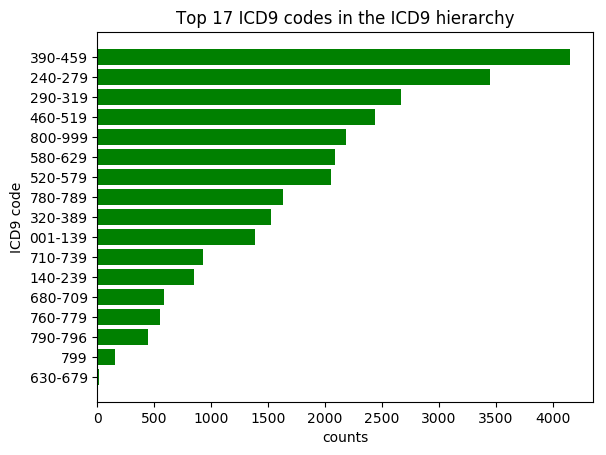

In [31]:
codes_counts =icd9_codes.items()
codes_counts.sort(key=itemgetter(1), reverse=True)
icd9_labels, values = zip(*codes_counts)
indexes = np.arange(len(icd9_labels))
plt.rcdefaults()
fig,ax = plt.subplots()
ax.barh(indexes, values,  align='center', color='green', ecolor='black')
ax.set_yticks(indexes)
ax.set_yticklabels(icd9_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('counts')
ax.set_ylabel('ICD9 code')
ax.set_title('Top 17 ICD9 codes in the ICD9 hierarchy')
plt.show()

In [32]:
#preprocess icd9 codes to vectors 
top_codes = ICD9_FIRST_LEVEL
labels = vectorization.vectorize_icd_column(df, 'ICD9', top_codes)


## Pre process Notes

In [34]:
#preprocess notes
MAX_VOCAB = None # to limit original number of words (None if no limit)
MAX_SEQ_LENGTH = 5000 # to limit length of word sequence (None if no limit)
df.TEXT = vectorization.clean_notes(df, 'TEXT')
data, dictionary, MAX_VOCAB = vectorization.vectorize_notes(df.TEXT, MAX_VOCAB, verbose = True)
data, MAX_SEQ_LENGTH = vectorization.pad_notes(data, MAX_SEQ_LENGTH)
print("Final Vocabulary: %s" % MAX_VOCAB)
print("Final Max Sequence Length: %s" % MAX_SEQ_LENGTH)

Vocabulary size: 44601
Average note length: 1629.28614801
Max note length: 8867
Final Vocabulary: 44601
Final Max Sequence Length: 5000


## Split Files

In [35]:
#split sets
X_train, X_val, X_test, y_train, y_val, y_test = helpers.train_val_test_split(
    data, labels, val_size=0.2, test_size=0.1, random_state=101)
print("Train: ", X_train.shape, y_train.shape)
print("Validation: ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

('Train: ', (3688, 5000), (3688, 19))
('Validation: ', (1054, 5000), (1054, 19))
('Test: ', (528, 5000), (528, 19))


In [36]:
# Delete temporary variables to free some memory
del df, data, labels

In [37]:
#creating embeddings
EMBEDDING_LOC = '../data/glove.6B.100d.txt' # location of embedding
EMBEDDING_DIM = 100 # given the glove that we chose
EMBEDDING_MATRIX, embedding_dict = vectorization.embedding_matrix(EMBEDDING_LOC,
                                                                  dictionary, EMBEDDING_DIM, verbose = True)


('Vocabulary in notes:', 44601)
('Vocabulary in original embedding:', 400000)
('Vocabulary intersection:', 21943)


## Super Basic Baseline with top 4
Always predict top 4

In [38]:
# finding out the top icd9 codes
top_4_icd9 = icd9_codes.most_common(4)
print "most common 4 icd9_codes: ", top_4_icd9
top_4_icd9_label = ' '.join(code for code,count in top_4_icd9 )
print 'label for the top 4 icd9 codes: ', top_4_icd9_label

most common 4 icd9_codes:  [('390-459', 4147), ('240-279', 3445), ('290-319', 2668), ('460-519', 2435)]
label for the top 4 icd9 codes:  390-459 240-279 290-319 460-519


In [42]:
#converting ICD9 prediction to a vector
top4_icd9_vector =  vectorization.vectorize_icd_string(top_4_icd9_label, ICD9_FIRST_LEVEL)
print ICD9_FIRST_LEVEL
print top4_icd9_vector

['001-139', '140-239', '240-279', '290-319', '320-389', '390-459', '460-519', '520-579', '580-629', '630-679', '680-709', '710-739', '760-779', '780-789', '790-796', '797', '798', '799', '800-999']
[0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [43]:
## assign icd9_prediction_vector to every discharge
train_y_hat_baseline = [top4_icd9_vector]* len (y_train)
dev_y_hat_baseline = [top4_icd9_vector]* len (y_val)

In [45]:
helpers.show_f1_score(y_train, train_y_hat_baseline, y_val, dev_y_hat_baseline)

F1 scores
threshold | training | dev  
0.020:      0.528      0.522
0.030:      0.528      0.522
0.040:      0.528      0.522
0.050:      0.528      0.522
0.055:      0.528      0.522
0.058:      0.528      0.522
0.060:      0.528      0.522
0.080:      0.528      0.522
0.100:      0.528      0.522
0.200:      0.528      0.522
0.300:      0.528      0.522
0.500:      0.528      0.522


## CNN for text classification

Based on the following papers and links:
* "Convolutional Neural Networks for Sentence Classification"   
* "A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification"
* http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
* https://github.com/alexander-rakhlin/CNN-for-Sentence-Classification-in-Keras/blob/master/sentiment_cnn.py
* http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/
* https://github.com/dennybritz/cnn-text-classification-tf/blob/master/text_cnn.py

In [48]:
reload(icd9_cnn_model)
#### build model
model = icd9_cnn_model.build_icd9_cnn_model (input_seq_length=MAX_SEQ_LENGTH, max_vocab = MAX_VOCAB,
                             external_embeddings = True, embedding_trainable =True,
                             embedding_dim=EMBEDDING_DIM,embedding_matrix=EMBEDDING_MATRIX,
                             num_filters = 100, filter_sizes=[2,3,4,5],
                             training_dropout_keep_prob=0.9,
                             num_classes=N_TOP )

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 5000)          0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 5000, 100)     4460200     input_3[0][0]                    
____________________________________________________________________________________________________
conv1d_9 (Conv1D)                (None, 4999, 100)     20100       embedding_3[0][0]                
____________________________________________________________________________________________________
conv1d_10 (Conv1D)               (None, 4998, 100)     30100       embedding_3[0][0]                
___________________________________________________________________________________________

In [49]:
# Train the model
model.fit(X_train, y_train, batch_size=50, epochs=5, validation_data=(X_val, y_val), verbose=2)

Train on 3688 samples, validate on 1054 samples
Epoch 1/5
106s - loss: 39.0906 - acc: 0.0895 - val_loss: 13.7156 - val_acc: 0.2505
Epoch 2/5
105s - loss: 20.0010 - acc: 0.0927 - val_loss: 13.2616 - val_acc: 0.1698
Epoch 3/5
105s - loss: 15.3538 - acc: 0.1236 - val_loss: 13.1849 - val_acc: 0.1461
Epoch 4/5
105s - loss: 14.1284 - acc: 0.1451 - val_loss: 13.1301 - val_acc: 0.1546
Epoch 5/5
105s - loss: 13.6890 - acc: 0.1630 - val_loss: 13.0755 - val_acc: 0.1366


In [50]:
pred_train = model.predict(X_train, batch_size=50)
pred_dev = model.predict(X_val, batch_size=50)

## Performance Evaluation

In [52]:
helpers.show_f1_score(y_train, pred_train, y_val, pred_dev)

F1 scores
threshold | training | dev  
0.020:      0.529      0.530
0.030:      0.567      0.566
0.040:      0.598      0.595
0.050:      0.620      0.612
0.055:      0.628      0.617
0.058:      0.631      0.618
0.060:      0.633      0.620
0.080:      0.616      0.589
0.100:      0.481      0.465
0.200:      0.024      0.023
0.300:      0.017      0.018
0.500:      0.005      0.004


### TO DO: model for Thresholding
Papers about Thresholding:    

* "Convolutional Neural Network using a Threshold Predictor for Multi-label Speech Act Classification"   
* "A Study on Threshold Selection for Multi-label Classification"   

These papers mention they use a model for thresholding, but it is not the main topic:   
* "A Review on Multi-Label Learning Algorithms"   
* "Large-scale Multi-label Text Classification—Revisiting Neural Networks"*   
* "A multi-label convolutional neural network for automatic image annotation"

### Results with external embeddings = True , no additional training,  top 20
```
F1 scores
threshold | training | dev  
0.020:      0.337      0.329
0.030:      0.360      0.353
0.040:      0.365      0.374
0.050:      0.372      0.375
0.055:      0.370      0.377
0.058:      0.369      0.375
0.060:      0.368      0.375
0.080:      0.348      0.361
0.100:      0.309      0.319
0.200:      0.198      0.208
0.300:      0.157      0.138
0.500:      0.000      0.000
```

### Results with external embeddings = False, top 20
```
F1 scores
threshold | training | dev  
0.020:      0.288      0.300
0.030:      0.327      0.322
0.040:      0.371      0.363
0.050:      0.380      0.391
0.055:      0.412      0.383
0.058:      0.403      0.394
0.060:      0.394      0.389
0.080:      0.385      0.390
0.100:      0.229      0.225
0.200:      0.000      0.000
0.300:      0.000      0.000
0.500:      0.000      0.000
```

### Results with external embedding and training them , top 20
```
F1 scores
threshold | training | dev  
0.020:      0.334      0.333
0.030:      0.362      0.360
0.040:      0.366      0.374
0.050:      0.373      0.380
0.055:      0.374      0.382
0.058:      0.376      0.376
0.060:      0.376      0.378
0.080:      0.387      0.371
0.100:      0.366      0.350
0.200:      0.179      0.171
0.300:      0.020      0.020
0.500:      0.000      0.000

```

### Results with external Embeddings = False, top 10, 
We can compare this setup with the LSTM published in the paper "Applying Deep Learning to ICD-9 Multi-label Classification from Medical Records", they got a F1-score of about 0.4168, we are getting 0.447

``` 
F1 scores
threshold | training | dev  
0.020:      0.399      0.407
0.030:      0.399      0.407
0.040:      0.399      0.407
0.050:      0.408      0.413
0.055:      0.433      0.420
0.058:      0.437      0.430
0.060:      0.432      0.427
0.080:      0.501      0.463
0.100:      0.446      0.463
0.200:      0.206      0.066
0.300:      0.000      0.000
0.500:      0.000      0.000
```



## Notes:


(1) There is a LSTM model by this paper: "Applying Deep Learning to ICD-9 Multi-label Classification from Medical Records" which did achieve a 42% F1-score. (https://cs224d.stanford.edu/reports/priyanka.pdf), but it only uses the top 10 icd9 codes. We are getting 46% (just running with 1000 notes so far)


(2) The "A Comparison of Rule-Based and Deep Learning Models for Patient Phenotyping"  study did get a 70% F1-score, but they don't use the icd9-labels but phenotypes labels they annotated themselved (via a group of medical professionals). (https://arxiv.org/abs/1703.08705). There were ONLY 10 phenotypes.

The discharge summaries are labeled with ICD9-codes that are leaves in the ICD9-hierarchy (which has hundreds of ICD9-codes), then maybe these leave nodes are too specific and difficult to predict, one experiment would be to replaced all the ICD9-codes with their parent in the second or third level in the hierarchy and see if predictions work better that way.   

(3) our baseline with top 20 codes had a f1-score of 35% (assigning top 4 icd9 codes to all notes, using a CNN with no external embeddings is getting about 40% f1-score.. a little better than the baseline

(4) Papers published and best practices report  that external embeddings improve considerable the model's performance.. maybe it is not the case here because of the medical terms..   

(5) Fixed Thresholding doesn't work well for multilabel classifications, we can implement a model to choose the appropriate threshold for each record (see notes above)

(6) for loss function: binary and categorical cross entropy gave same results